# 01 — Khám phá dữ liệu (EDA): NYC Airbnb 2019

**Mục tiêu**
- Nắm cấu trúc dữ liệu: kích thước, các cột, kiểu dữ liệu, thiếu/khác thường
- Thống kê mô tả các biến số; phân phối *price*, *minimum_nights*, ...
- Quan sát tương quan và các mẫu đơn giản theo *neighbourhood_group*, *room_type*
- Trực quan hóa cơ bản (Matplotlib/Seaborn) - xử lý **chỉ bằng NumPy**

**Nguồn dữ liệu**
- Dataset: *New York City Airbnb Open Data* trên Kaggle, file `AB_NYC_2019.csv` (~48–49k dòng, 16 cột; liệt kê thông tin listing, host, vị trí, giá, loại phòng, review, …)

**Ghi chú kỹ thuật**
- Phần **xử lý/tính toán** dùng **NumPy** (tuân thủ đề bài)
- Phần **vẽ** dùng Matplotlib (Seaborn nếu có)
- Các hàm tái sử dụng đã đặt trong thư mục `src/`:  
  `data_processing.py`, `visualization.py`, `models.py` (chỉ dùng `models.py` khi cần phần nâng cao)

In [1]:
# Xác định ROOT sao cho linh hoạt khi mở notebook từ project 
from pathlib import Path
import sys

ROOT = Path.cwd()
if not (ROOT / "src").exists() and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent

print(ROOT)
sys.path.insert(0, str(ROOT))

/home/khoaoe/ds_programming/lab/lab02/airbnb


## Khởi tạo & import

In [2]:
import numpy as np

# Import các API đã chuẩn hóa trong src/__init__.py
from src import (
    load_airbnb, find_csv, to_columns,
    numeric_cols, categorical_cols,
    missing_summary, unique_summary, describe_numeric,
    groupby_reduce, topk_counts, corr_matrix,
    plot_hist, plot_bar_counts, plot_scatter_geo,
    plot_corr_heatmap, plot_box_by_cat
)

# data path
DATA_ROOT = ROOT / "data" / "raw"

## 1) Nạp dữ liệu & kiểm tra nhanh

- Đọc CSV → dict `{column -> ndarray}`, trong đó cột ngày đã parse sang `datetime64[D]`.
- Kiểm tra kích thước, danh sách cột, kiểu dữ liệu.

In [3]:
# Load dữ liệu
csv_path = find_csv(str(DATA_ROOT)) if DATA_ROOT.exists() else str(ROOT / "data" / "AB_NYC_2019.csv")
cols = load_airbnb(csv_path)

# Kích thước & danh sách cột
n_rows = len(next(iter(cols.values())))
col_names = list(cols.keys())

print(f"File: {csv_path}")
print(f"Số dòng: {n_rows}")
print(f"Số cột : {len(col_names)}")
print("Các cột :", col_names[:])

# In kiểu dữ liệu từng cột (NumPy dtype)
print("\nKiểu dữ liệu:")
for k, v in cols.items():
    print(f"  - {k:30s}: {v.dtype}")

File: /home/khoaoe/ds_programming/lab/lab02/airbnb/data/raw/AB_NYC_2019.csv
Số dòng: 48895
Số cột : 16
Các cột : ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

Kiểu dữ liệu:
  - id                            : float64
  - name                          : <U179
  - host_id                       : float64
  - host_name                     : <U35
  - neighbourhood_group           : <U13
  - neighbourhood                 : <U26
  - latitude                      : float64
  - longitude                     : float64
  - room_type                     : <U15
  - price                         : float64
  - minimum_nights                : float64
  - number_of_reviews             : float64
  - last_review                   : datetime64[D]
  - reviews_per_month             : float64
  - calcu

## 2) Quan sát 5 dòng đầu (theo cột quan trọng)

- In nhanh một số cột thường dùng để EDA: `id, name, neighbourhood_group, neighbourhood, room_type, price, minimum_nights, number_of_reviews, last_review, reviews_per_month`.

In [4]:
# In 5 bản ghi đầu, chọn subset cột thường dùng
show_cols = [
    "id", "name", "neighbourhood_group", "neighbourhood",
    "room_type", "price", "minimum_nights", "number_of_reviews",
    "last_review", "reviews_per_month"
]
show_cols = [c for c in show_cols if c in cols]

k = min(5, n_rows)
for i in range(k):
    row = {c: cols[c][i] for c in show_cols}
    print(row)

{'id': 2539.0, 'name': 'Clean & quiet apt home by the park', 'neighbourhood_group': 'Brooklyn', 'neighbourhood': 'Kensington', 'room_type': 'Private room', 'price': 149.0, 'minimum_nights': 1.0, 'number_of_reviews': 9.0, 'last_review': numpy.datetime64('2018-10-19'), 'reviews_per_month': 0.21}
{'id': 2595.0, 'name': 'Skylit Midtown Castle', 'neighbourhood_group': 'Manhattan', 'neighbourhood': 'Midtown', 'room_type': 'Entire home/apt', 'price': 225.0, 'minimum_nights': 1.0, 'number_of_reviews': 45.0, 'last_review': numpy.datetime64('2019-05-21'), 'reviews_per_month': 0.38}
{'id': 3647.0, 'name': 'THE VILLAGE OF HARLEM....NEW YORK !', 'neighbourhood_group': 'Manhattan', 'neighbourhood': 'Harlem', 'room_type': 'Private room', 'price': 150.0, 'minimum_nights': 3.0, 'number_of_reviews': 0.0, 'last_review': numpy.datetime64('NaT'), 'reviews_per_month': nan}
{'id': 3831.0, 'name': 'Cozy Entire Floor of Brownstone', 'neighbourhood_group': 'Brooklyn', 'neighbourhood': 'Clinton Hill', 'room_type

## 3) Thiếu dữ liệu & tính duy nhất ở cột phân loại

- **Thiếu dữ liệu**: đếm số lượng và tỷ lệ % theo cột.
- **Số giá trị khác nhau**: với cột phân loại (`name, host_name, neighbourhood_group, neighbourhood, room_type`).


In [5]:
# Tóm tắt thiếu dữ liệu
miss_tbl = missing_summary(cols)
print("Tóm tắt thiếu dữ liệu theo cột:")
print(miss_tbl)

# %% Unique summary cho cột phân loại
uniq_tbl = unique_summary(cols, categorical_cols)
print("\nSố giá trị khác nhau ở cột phân loại:")
print(uniq_tbl)

Tóm tắt thiếu dữ liệu theo cột:
[('id',     0,  0.        ) ('name',    16,  0.03272318)
 ('host_id',     0,  0.        ) ('host_name',    21,  0.04294918)
 ('neighbourhood_group',     0,  0.        )
 ('neighbourhood',     0,  0.        ) ('latitude',     0,  0.        )
 ('longitude',     0,  0.        ) ('room_type',     0,  0.        )
 ('price',     0,  0.        ) ('minimum_nights',     0,  0.        )
 ('number_of_reviews',     0,  0.        )
 ('last_review', 10052, 20.5583393 )
 ('reviews_per_month', 10052, 20.5583393 )
 ('calculated_host_listings_count',     0,  0.        )
 ('availability_365',     0,  0.        )]

Số giá trị khác nhau ở cột phân loại:
[('name', 47895, 9.79548011e+01) ('host_name', 11453, 2.34236630e+01)
 ('neighbourhood_group',     5, 1.02259945e-02)
 ('neighbourhood',   221, 4.51988956e-01)
 ('room_type',     3, 6.13559669e-03)]


## 4) Thống kê mô tả các biến số

- Dùng NumPy để tính `min, p25, p50, p75, max, mean, std`.
- Tập cột số mặc định: `id, host_id, latitude, longitude, price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count, availability_365`.

In [6]:
# Describe numeric (NumPy only)
desc_tbl = describe_numeric(cols, numeric_cols)
print("Thống kê mô tả (cột số):")
print(desc_tbl)

Thống kê mô tả (cột số):
[('id',  2.539000e+03,  9.471945e+06,  1.9677284e+07,  2.91521785e+07,  3.64872450e+07,  1.90171432e+07, 1.09831084e+07)
 ('host_id',  2.438000e+03,  7.822033e+06,  3.0793816e+07,  1.07434423e+08,  2.74321313e+08,  6.76200106e+07, 7.86109670e+07)
 ('latitude',  4.049979e+01,  4.069010e+01,  4.0723070e+01,  4.07631150e+01,  4.09130600e+01,  4.07289489e+01, 5.45300781e-02)
 ('longitude', -7.424442e+01, -7.398307e+01, -7.3955680e+01, -7.39362750e+01, -7.37129900e+01, -7.39521696e+01, 4.61567361e-02)
 ('price',  0.000000e+00,  6.900000e+01,  1.0600000e+02,  1.75000000e+02,  1.00000000e+04,  1.52720687e+02, 2.40154170e+02)
 ('minimum_nights',  1.000000e+00,  1.000000e+00,  3.0000000e+00,  5.00000000e+00,  1.25000000e+03,  7.02996216e+00, 2.05105495e+01)
 ('number_of_reviews',  0.000000e+00,  1.000000e+00,  5.0000000e+00,  2.40000000e+01,  6.29000000e+02,  2.32744657e+01, 4.45505823e+01)
 ('reviews_per_month',  1.000000e-02,  1.900000e-01,  7.2000000e-01,  2.02000000

## 5) Trực quan phân phối & quan hệ cơ bản

- **Histogram** cho `price` (thử thêm log-scale để nhìn rõ đuôi dài).
- **Bar chart** Top-10 `neighbourhood_group` / `room_type`.
- **Geo scatter**: phân bố điểm theo (lon, lat), tô màu theo `price`.
- **Boxplot**: `price` theo `room_type` để thấy khác biệt theo loại phòng.


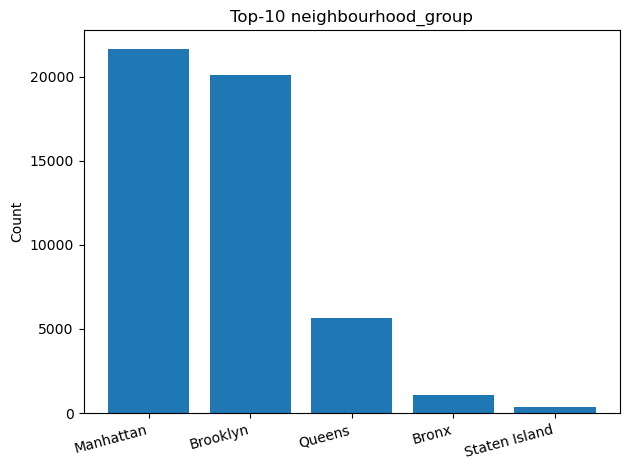

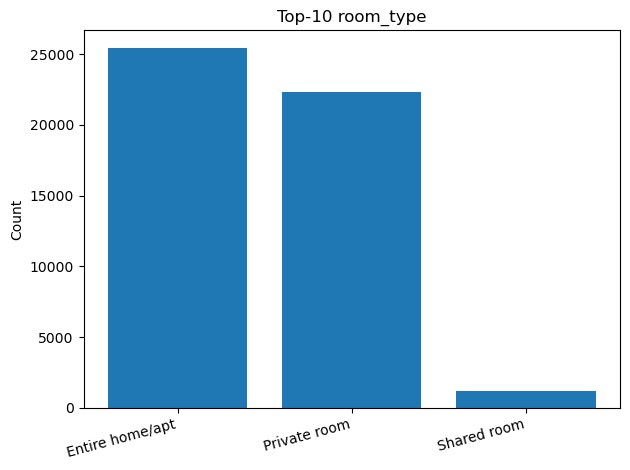

In [7]:
# Bar chart tần suất theo nhóm
if "neighbourhood_group" in cols:
    plot_bar_counts(cols["neighbourhood_group"], topk=10, title="Top-10 neighbourhood_group", rotation=15)

if "room_type" in cols:
    plot_bar_counts(cols["room_type"], topk=10, title="Top-10 room_type", rotation=15)


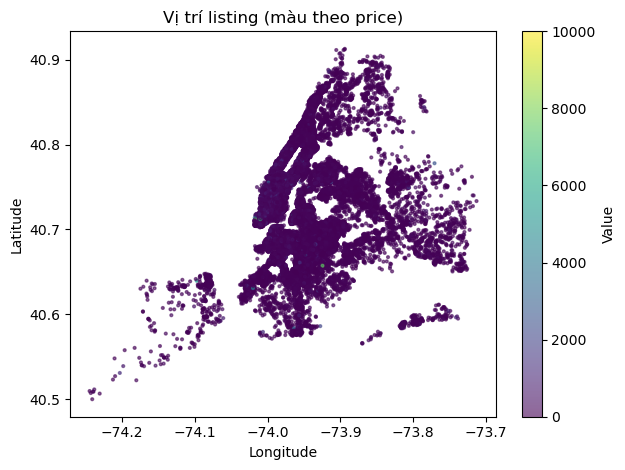

In [8]:
# Scatter địa lý (lon, lat) tô màu theo price
plot_scatter_geo(cols["latitude"], cols["longitude"], c=cols["price"], s=4, title="Vị trí listing (màu theo price)")

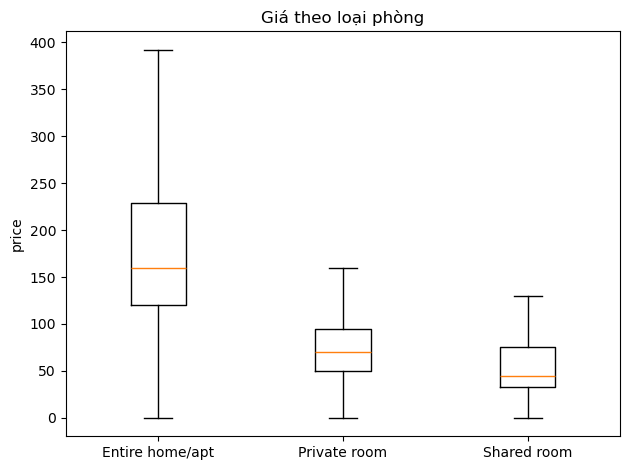

In [9]:
# Boxplot price ~ room_type (ẩn outlier để nhìn median rõ hơn)
if "room_type" in cols:
    plot_box_by_cat(cols["price"].astype(float), cols["room_type"], title="Giá theo loại phòng", ylabel="price")

## 6) Tương quan giữa các biến số

- Chọn một tập biến số thường liên quan đến giá:  
  `["price","minimum_nights","number_of_reviews","reviews_per_month","calculated_host_listings_count","availability_365"]`
- Tính ma trận tương quan Pearson (bỏ hàng có NaN) và vẽ heatmap

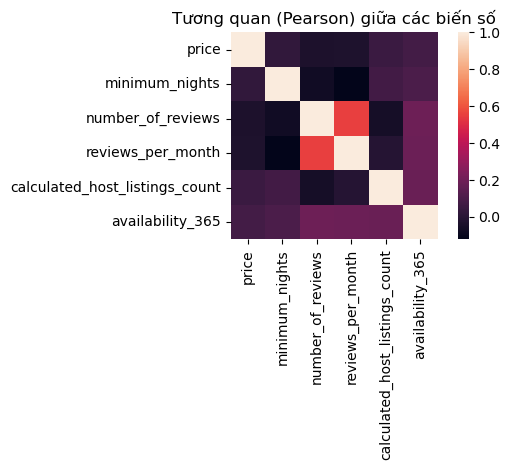

In [10]:
# Corr matrix + heatmap
num_for_corr = [
    "price", "minimum_nights", "number_of_reviews", "reviews_per_month",
    "calculated_host_listings_count", "availability_365"
]
C, labels = corr_matrix(cols, num_for_corr)
plot_corr_heatmap(C, labels, title="Tương quan (Pearson) giữa các biến số")


## 7) Nhóm theo khu vực: giá trung bình

- Tính giá trung bình theo `neighbourhood_group` và theo `room_type`.
- Mục tiêu: nắm vùng/loại phòng nào có mức giá cao/thấp trung bình

In [11]:
# Giá trung bình theo neighbourhood_group
if "neighbourhood_group" in cols:
    k, v = groupby_reduce(cols["neighbourhood_group"], cols["price"].astype(float), how="mean")
    order = np.argsort(-v)  # giảm dần
    print("Giá trung bình theo neighbourhood_group (giảm dần):")
    for name, val in zip(k[order], v[order]):
        print(f"{name:15s} : {val:8.2f}")

# Giá trung bình theo room_type
if "room_type" in cols:
    k2, v2 = groupby_reduce(cols["room_type"], cols["price"].astype(float), how="mean")
    order2 = np.argsort(-v2)
    print("\nGiá trung bình theo room_type (giảm dần):")
    for name, val in zip(k2[order2], v2[order2]):
        print(f"{name:15s} : {val:8.2f}")

Giá trung bình theo neighbourhood_group (giảm dần):
Manhattan       :   196.88
Brooklyn        :   124.38
Staten Island   :   114.81
Queens          :    99.52
Bronx           :    87.50

Giá trung bình theo room_type (giảm dần):
Entire home/apt :   211.79
Private room    :    89.78
Shared room     :    70.13


## 8) Ghi nhận nhanh & hướng EDA tiếp theo

**Nhận xét sơ bộ** (gợi ý, sẽ thay bằng quan sát thực tế sau khi chạy):
- Phân phối *price* lệch phải mạnh (đuôi dài) → log-scale hữu ích.
- Giá trung bình khác biệt theo *room_type* và *neighbourhood_group*.
- Tương quan: *price* thường không tương quan mạnh với *number_of_reviews*; *availability_365* có thể phản ánh mức cho thuê theo năm hơn là giá.

**Tiếp theo (nếu cần)**:
- Làm sạch ngoại lệ thô sơ (ví dụ: *minimum_nights* quá lớn).  
- Thử *feature* đơn giản cho phần modeling (bonus): one-hot `room_type`, `neighbourhood_group`, chuẩn hoá số, **NumPy-only**

## Phụ lục: Tái sử dụng & reproducibility

- Notebook này chỉ gọi hàm từ `src/` để dễ bảo trì:
  - `src/data_processing.py`: nạp dữ liệu, thống kê thiếu/unique, describe, groupby, corr.
  - `src/visualization.py`: các hàm vẽ phổ biến (hist, bar, geo-scatter, heatmap, boxplot).
  - `src/models.py`: tiện ích modeling cơ bản (không bắt buộc trong EDA).

- Khi di chuyển máy/chạy trên Kaggle:
  - Đặt dữ liệu vào `data/raw/AB_NYC_2019.csv` hoặc chỉnh `DATA_ROOT`.
  - Đảm bảo `src/` nằm cạnh notebook để `from src import ...` hoạt động